This notebook demonstrates how Self Supervised Learning works

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [18]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [19]:
x_train = x_train.astype('float32') / 255.0

In [20]:


# Define our 5 Permutations
# Labels: 0=Original, 1=Reversed, 2=Horizontal Flip, 3=Vertical Flip, 4=Diagonal Swap
perms = [
    [0, 1, 2, 3], [3, 2, 1, 0], [1, 0, 3, 2], [2, 3, 0, 1], [0, 2, 1, 3]
]

def create_jigsaw_data(image_batch, permutations):
    """
    Takes a batch of images and returns (X, y)
    X: Flattened, shuffled patches
    y: One-hot encoded permutation labels
    """
    X_list = []
    y_list = []
    
    for img in image_batch:
        # 1. Slice into 2x2 patches
        p = [img[0:14, 0:14], img[0:14, 14:28], 
             img[14:28, 0:14], img[14:28, 14:28]]
        
        # 2. Pick a random permutation index
        idx = np.random.randint(0, len(permutations))
        order = permutations[idx]
        
        # 3. Shuffle patches and flatten
        shuffled = [p[i].flatten() for i in order]
        X_list.append(np.concatenate(shuffled))
        
        # 4. Create one-hot label
        label = np.zeros(len(permutations))
        label[idx] = 1
        y_list.append(label)
        
    return np.array(X_list), np.array(y_list)

In [21]:
# Hyperparameters
input_size = 784
hidden_size = 128
output_size = 5
learning_rate = 0.01

# Weights and Biases
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

In [22]:

# 1. Activation Functions
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

# 2. Training Loop
epochs = 1000
batch_size = 32
loss_history = []

for i in range(epochs):
    # Get a batch of Jigsaw data
    random_indices = np.random.randint(0, len(x_train), batch_size)
    X_batch, y_batch = create_jigsaw_data(x_train[random_indices], perms)
    
    # --- FORWARD PASS ---
    Z1 = np.dot(X_batch, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    
    # --- CALC LOSS (Cross-Entropy) ---
    loss = -np.mean(np.sum(y_batch * np.log(A2 + 1e-8), axis=1))
    loss_history.append(loss)
    
    # --- BACKPROPAGATION ---
    dZ2 = A2 - y_batch
    dW2 = np.dot(A1.T, dZ2) / batch_size
    db2 = np.sum(dZ2, axis=0, keepdims=True) / batch_size
    
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X_batch.T, dZ1) / batch_size
    db1 = np.sum(dZ1, axis=0, keepdims=True) / batch_size
    
    # --- UPDATE WEIGHTS ---
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss:.4f}")

Iteration 0, Loss: 1.6118
Iteration 100, Loss: 1.5706
Iteration 200, Loss: 1.3797
Iteration 300, Loss: 0.8872
Iteration 400, Loss: 0.4615
Iteration 500, Loss: 0.2309
Iteration 600, Loss: 0.1699
Iteration 700, Loss: 0.1133
Iteration 800, Loss: 0.0649
Iteration 900, Loss: 0.0468


In [23]:
def visualize_prediction(image, model_weights, permutations):
    # 1. Prepare the scrambled input (let's use Permutation #1: [3, 2, 1, 0])
    p = [image[0:14, 0:14], image[0:14, 14:28], 
         image[14:28, 0:14], image[14:28, 14:28]]
    
    true_idx = 1
    shuffled_order = permutations[true_idx]
    shuffled_patches = [p[i] for i in shuffled_order]
    
    # Flatten for the model
    X_input = np.concatenate([p.flatten() for p in shuffled_patches]).reshape(1, -1)
    
    # 2. Forward Pass (Prediction)
    z1 = np.dot(X_input, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    probs = softmax(z2)
    pred_idx = np.argmax(probs)
    
    # 3. Reconstruct based on prediction
    # We need to map the shuffled patches back to their predicted original spots
    predicted_order = permutations[pred_idx]
    # (Logic to re-order patches goes here)
    
    print(f"True Permutation: {true_idx}, Predicted: {pred_idx}")

In [24]:
# 1. Pick a random test image
test_idx = np.random.randint(0, len(x_test))
img = x_test[test_idx].astype('float32') / 255.0

# 2. Slice and Scramble using Permutation #1 (index 1)
# Permutation #1: [3, 2, 1, 0] (Full reversal)
true_perm_idx = 1
order = perms[true_perm_idx]

patches = [img[0:14, 0:14], img[0:14, 14:28], 
           img[14:28, 0:14], img[14:28, 14:28]]

# Arrange and flatten for the network
shuffled_X = np.concatenate([patches[i].flatten() for i in order]).reshape(1, -1)

# 3. Forward Pass (Inference)
z1_test = np.dot(shuffled_X, W1) + b1
a1_test = relu(z1_test)
z2_test = np.dot(a1_test, W2) + b2
predictions = softmax(z2_test)

# 4. Show Result
predicted_idx = np.argmax(predictions)
print(f"True Permutation Index: {true_perm_idx}")
print(f"Model Predicted Index: {predicted_idx}")
print(f"Confidence: {predictions[0][predicted_idx]*100:.2f}%")

True Permutation Index: 1
Model Predicted Index: 1
Confidence: 94.67%


In [25]:
def reconstruct_image(shuffled_patches, pred_idx):
    """
    Rearranges shuffled patches into their original 2x2 grid positions 
    based on the predicted permutation index.
    """
    # perms = [[0, 1, 2, 3], [3, 2, 1, 0], [1, 0, 3, 2], [2, 3, 0, 1], [0, 2, 1, 3]]
    
    if pred_idx == 0:   # Original: [0, 1, 2, 3]
        p0, p1, p2, p3 = shuffled_patches[0], shuffled_patches[1], shuffled_patches[2], shuffled_patches[3]
    elif pred_idx == 1: # Fully Reversed: [3, 2, 1, 0]
        p3, p2, p1, p0 = shuffled_patches[0], shuffled_patches[1], shuffled_patches[2], shuffled_patches[3]
    elif pred_idx == 2: # Horizontal Flip: [1, 0, 3, 2]
        p1, p0, p3, p2 = shuffled_patches[0], shuffled_patches[1], shuffled_patches[2], shuffled_patches[3]
    elif pred_idx == 3: # Vertical Flip: [2, 3, 0, 1]
        p2, p3, p0, p1 = shuffled_patches[0], shuffled_patches[1], shuffled_patches[2], shuffled_patches[3]
    elif pred_idx == 4: # Diagonal Swap: [0, 2, 1, 3]
        p0, p2, p1, p3 = shuffled_patches[0], shuffled_patches[1], shuffled_patches[2], shuffled_patches[3]
    else:
        return None

    # Use np.block to assemble the 14x14 patches into a 28x28 image
    return np.block([[p0, p1], [p2, p3]])

In [26]:
def plot_poc_results(original, scrambled_patches, reconstructed, pred_idx, true_idx):
    plt.figure(figsize=(12, 4))
    
    # 1. Original
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Digit")
    plt.axis('off')
    
    # 2. Scrambled (We re-assemble the scrambled patches just for viewing)
    plt.subplot(1, 3, 2)
    scrambled_img = np.block([[scrambled_patches[0], scrambled_patches[1]], 
                              [scrambled_patches[2], scrambled_patches[3]]])
    plt.imshow(scrambled_img, cmap='gray')
    plt.title(f"Scrambled (Perm #{true_idx})")
    plt.axis('off')
    
    # 3. Reconstructed
    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed, cmap='gray')
    plt.title(f"Model Fix (Pred #{pred_idx})")
    plt.axis('off')
    
    plt.show()

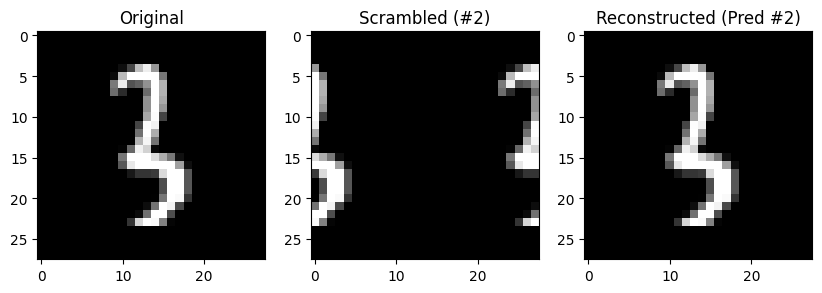

In [27]:
def test_and_visualize(model_weights, perms):
    W1, b1, W2, b2 = model_weights
    
    # 1. Pick a random test image and scramble it
    test_img = x_test[np.random.randint(0, len(x_test))]
    true_idx = np.random.randint(0, len(perms))
    
    # Slice into 2x2 patches
    p = [test_img[0:14, 0:14], test_img[0:14, 14:28], 
         test_img[14:28, 0:14], test_img[14:28, 14:28]]
    
    # Shuffle based on the chosen permutation
    shuffled_order = perms[true_idx]
    shuffled_patches = [p[i] for i in shuffled_order]
    
    # 2. Predict
    X_input = np.concatenate([patch.flatten() for patch in shuffled_patches]).reshape(1, -1)
    z1 = np.dot(X_input, W1) + b1
    a1 = np.maximum(0, z1) # ReLU
    z2 = np.dot(a1, W2) + b2
    pred_idx = np.argmax(z2) # Predicted permutation index
    
    # 3. Use your if-elif logic to reconstruct
    # (Inserting your reconstruction logic here...)
    recon = reconstruct_image(shuffled_patches, pred_idx)
    
    # 4. Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(test_img, cmap='gray'); plt.title("Original")
    
    plt.subplot(1, 3, 2)
    scrambled_view = np.block([[shuffled_patches[0], shuffled_patches[1]], 
                               [shuffled_patches[2], shuffled_patches[3]]])
    plt.imshow(scrambled_view, cmap='gray'); plt.title(f"Scrambled (#{true_idx})")
    
    plt.subplot(1, 3, 3)
    plt.imshow(recon, cmap='gray'); plt.title(f"Reconstructed (Pred #{pred_idx})")
    plt.show()

# Run the test
test_and_visualize((W1, b1, W2, b2), perms)